In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
import networkx as nx
from collections import defaultdict
import matplotlib.cm as cm
import numpy as np


In [2]:
df = pd.read_csv("cleaned_dataset.csv")

In [3]:
suspicious_scores = defaultdict(int) #default value 0 

In [4]:
G = nx.DiGraph() # directed graph
def clean_address(addr):
    return addr.split('_')[-1] if '_' in addr else addr # Seller_0x0a2 = Buyer_0x0a2

cleaned_edges = defaultdict(int)
for u, v, d in G.edges(data=True):
    u_clean = clean_address(u) #starting node
    v_clean = clean_address(v) #ending node
    weight = d.get('weight', 1) # if exists assign 'weight' otherwise 1
    cleaned_edges[(u_clean, v_clean)] += weight

In [5]:
for idx, row in df.iterrows():
    seller_clean = clean_address(row['seller.address'])
    buyer_clean = clean_address(row['winner_account.address'])
    price = row['usd_price']

    if G.has_edge(seller_clean, buyer_clean): # if exists
        G[seller_clean][buyer_clean]['weight'] += 1
        G[seller_clean][buyer_clean]['total_price'] += price
    else:
        G.add_edge(seller_clean, buyer_clean, weight=1, total_price=price) # if not already in graph then add it 

print(f"Total number of nodes (cleaned addresses): {G.number_of_nodes()}")
print(f"Total number of edges: {G.number_of_edges()}")

Total number of nodes (cleaned addresses): 4096
Total number of edges: 3862930


In [6]:
cleaned_edges = {(u, v): d for u, v, d in G.edges(data=True)} # d =dictionary
# dict comprehension

In [7]:
# suspicious edges having >= 5 transactions
threshold = 5
suspicious_edges = [(u, v, d) for (u, v), d in cleaned_edges.items() if d['weight'] > threshold] #list comprehension
print(f"\nNumber of suspicious edges (more than 5 transactions): {len(suspicious_edges)}")

# update score
for u, v, d in suspicious_edges:
    suspicious_scores[u] += d['weight']
    suspicious_scores[v] += d['weight']

# top 10
print("\nExamples of suspicious address pairs (more than 5 transactions):")
for u, v, d in suspicious_edges[:10]:
    print(f"{u} -> {v}, number of transactions: {d['weight']}, total USD price: {d['total_price']:.2f}")

# items turns key value pairs for a list
top_scores = sorted(suspicious_scores.items(), key=lambda x: x[1], reverse=True) # x= address, value, x[0] = address, x[1]= value sort by this
top_users_df = pd.DataFrame(top_scores[:10], columns=["Address", "Score"])
print("\nTop 10 suspicious users (based on >5 transactions between pairs):")
print(top_users_df.to_string(index=False))


Number of suspicious edges (more than 5 transactions): 35016

Examples of suspicious address pairs (more than 5 transactions):
0xf88 -> 0xcb7, number of transactions: 7, total USD price: 2171.82
0xf88 -> 0x0a2, number of transactions: 9, total USD price: 3243.68
0xf88 -> 0x16e, number of transactions: 6, total USD price: 263.62
0xf88 -> 0xc3c, number of transactions: 16, total USD price: 2376.55
0xf88 -> 0x99a, number of transactions: 6, total USD price: 639.64
0xf88 -> 0x13d, number of transactions: 6, total USD price: 160.58
0xf88 -> 0x2ec, number of transactions: 13, total USD price: 5050.18
0xf88 -> 0x947, number of transactions: 6, total USD price: 1690.35
0x7eb -> 0x0a2, number of transactions: 11, total USD price: 9264.01
0xf29 -> 0xa4e, number of transactions: 7, total USD price: 5192.02

Top 10 suspicious users (based on >5 transactions between pairs):
Address  Score
  0x0a2  47589
  0xefe   7191
  0x090   6563
  0x073   4203
  0x2d8   3748
  0xa14   3575
  0xbdd   3479
  0xb

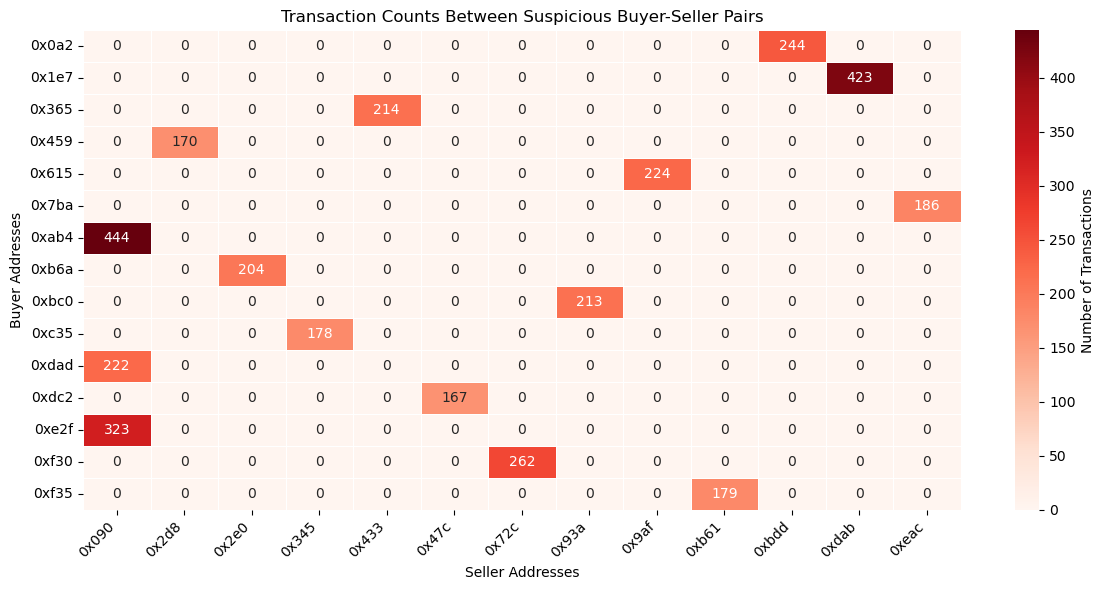

In [8]:
top_edge_pairs = sorted(suspicious_edges, key=lambda x: x[2]['weight'], reverse=True)[:15] # x = u v d, x[0]=u, x[1] = v, x[2]=d sort by this

# u=seller address, v = buyer address, d = dictionary
sellers = sorted(list(set([u for u, _, _ in top_edge_pairs])))
buyers = sorted(list(set([v for _, v, _ in top_edge_pairs])))


heatmap_data = pd.DataFrame(0, index=buyers, columns=sellers) # default:fill with 0

# fill data
for u, v, d in top_edge_pairs:
    heatmap_data.loc[v, u] = d['weight']

# heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Reds", linewidths=.5, cbar_kws={"label": "Number of Transactions"})
plt.title("Transaction Counts Between Suspicious Buyer-Seller Pairs")
plt.xlabel("Seller Addresses")
plt.ylabel("Buyer Addresses")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


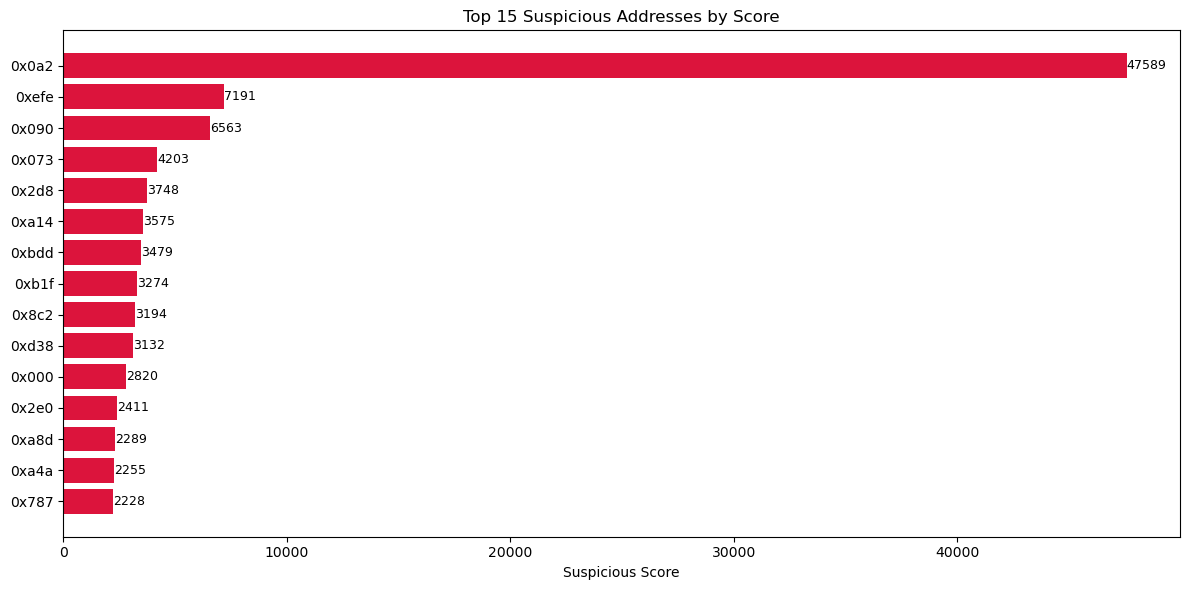

In [9]:
# Top 15 suspicious addresses by score
top_scores = sorted(suspicious_scores.items(), key=lambda x: x[1], reverse=True)[:15]
top_df = pd.DataFrame(top_scores, columns=["Address", "Suspicious Score"])


plt.figure(figsize=(12, 6))
bars = plt.barh(top_df["Address"], top_df["Suspicious Score"], color='crimson')
plt.xlabel("Suspicious Score")
plt.title("Top 15 Suspicious Addresses by Score")

# write scores to end of bars
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             str(int(bar.get_width())),
             va='center', fontsize=9)

plt.gca().invert_yaxis()  # En yüksek skoru üste al
plt.tight_layout()
plt.show()


In [10]:
# Step 2: Bidirectional transactions
# suspicious score for this step only
bidirectional_scores = defaultdict(int)

suspicious_pairs = []
seen_pairs = set()

for (u, v), w1 in cleaned_edges.items():
    if (v, u) in cleaned_edges and (v, u) not in seen_pairs:
        w2 = cleaned_edges[(v, u)] # w2 = u, v, weight, total_price
        total = w1['weight'] + w2['weight']  
        if total >= 2:
            suspicious_pairs.append((u, v, w1['weight'], w2['weight']))
            suspicious_scores[u] += 2
            suspicious_scores[v] += 2
            bidirectional_scores[u] += 2
            bidirectional_scores[v] += 2
            seen_pairs.add((u, v))# every pair added just once
            seen_pairs.add((v, u)) # every pair gets 2 points
            # some addresses have high values because they involved in many transactions


print("\nSuspicious bidirectional edges:")
if suspicious_pairs:
    for u, v, w1, w2 in suspicious_pairs[:10]:
        print(f"{u} <-> {v}: {w1} ->, {w2} <- transactions (score +2)")
else:
    print("No suspicious edge found.")


print("\nTop 10 suspicious users based on bidirectional transactions (step 2):")
top_bidir_scores = sorted(bidirectional_scores.items(), key=lambda x: x[1], reverse=True)
if top_bidir_scores:
    for addr, score in top_bidir_scores[:10]:
        print(f"{addr}: {score} points")
else:
    print("No suspicious user found in bidirectional transactions.")



Suspicious bidirectional edges:
0xf88 <-> 0x7eb: 1 ->, 2 <- transactions (score +2)
0xf88 <-> 0xcf1: 1 ->, 2 <- transactions (score +2)
0xf88 <-> 0xe8b: 1 ->, 1 <- transactions (score +2)
0xf88 <-> 0xb28: 1 ->, 3 <- transactions (score +2)
0xf88 <-> 0xcd7: 1 ->, 1 <- transactions (score +2)
0xf88 <-> 0xb77: 1 ->, 1 <- transactions (score +2)
0xf88 <-> 0x7f5: 1 ->, 1 <- transactions (score +2)
0xf88 <-> 0xb2f: 1 ->, 1 <- transactions (score +2)
0xf88 <-> 0x92d: 1 ->, 1 <- transactions (score +2)
0xf88 <-> 0xc9a: 1 ->, 1 <- transactions (score +2)

Top 10 suspicious users based on bidirectional transactions (step 2):
0x0a2: 3160 points
0xbdd: 2668 points
0x000: 2440 points
0xd5a: 2162 points
0xf91: 2022 points
0x676: 1756 points
0x050: 1740 points
0x997: 1738 points
0x520: 1734 points
0xb32: 1674 points


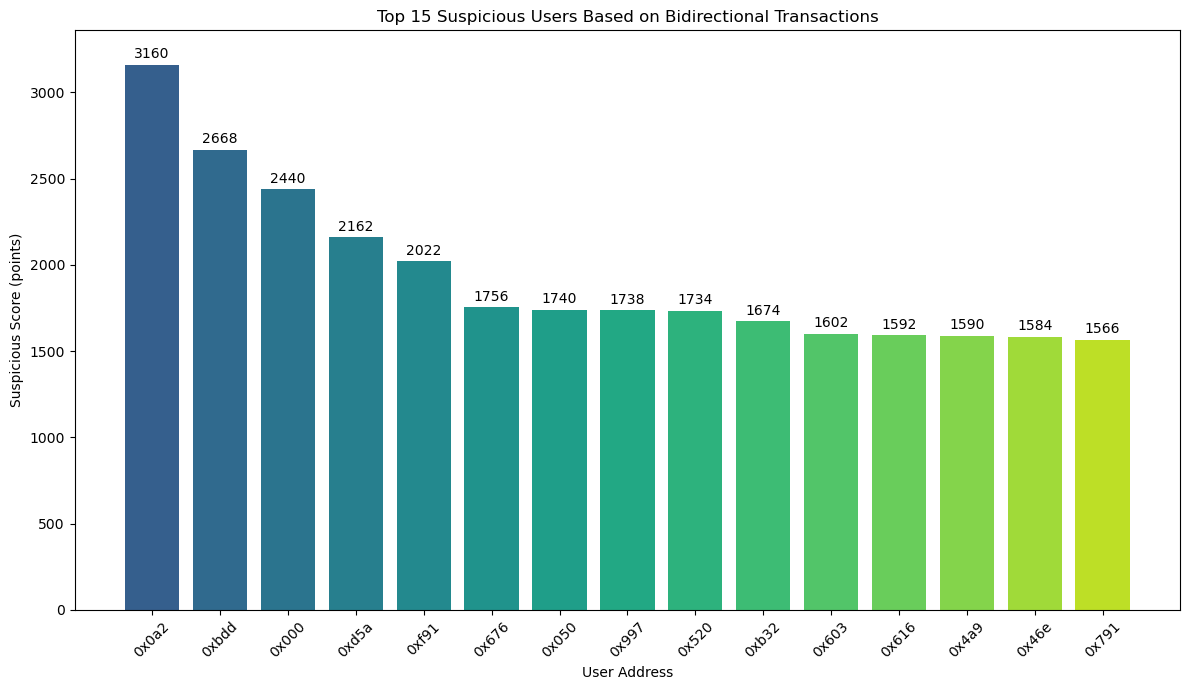

In [11]:


#top 15 user based on bidirectional_scores
top_15 = sorted(bidirectional_scores.items(), key=lambda x: x[1], reverse=True)[:15]

# separate user addresses and scores
users = [item[0] for item in top_15]
scores = [item[1] for item in top_15]

colors = cm.viridis(np.linspace(0.3, 0.9, len(scores)))  # 0.3-0.9 color tones

plt.figure(figsize=(12, 7))
bars = plt.bar(users, scores, color=colors)

plt.title("Top 15 Suspicious Users Based on Bidirectional Transactions")
plt.xlabel("User Address")
plt.ylabel("Suspicious Score (points)")
plt.xticks(rotation=45)
plt.ylim(0, max(scores) + 200)

# to write the scores on top of bars
for bar, score in zip(bars, scores): # matches bars and scores
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 20, score, ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [12]:
df['sales_datetime'] = pd.to_datetime(df['sales_datetime'])
df['date_only'] = df['sales_datetime'].dt.date

df['seller_clean'] = df['seller.address'].apply(clean_address)
df['buyer_clean'] = df['winner_account.address'].apply(clean_address)

In [13]:
#High-Frequency Same-Day Trades

from collections import defaultdict

# new score variable for this step
step3_scores = defaultdict(int)

grouped = df.groupby(['seller_clean', 'buyer_clean', 'date_only']).size().reset_index(name='transaction_count')
#group seller, buyer and date then create a transcation_count variable

# Identify suspicious pairs with 4 or more transactions on the same day
threshold = 4
suspicious_daily_trades = grouped[grouped['transaction_count'] >= threshold]


#index, row
for _, row in suspicious_daily_trades.iterrows():
    suspicious_scores[row['seller_clean']] += row['transaction_count']
    suspicious_scores[row['buyer_clean']] += row['transaction_count']
    
    step3_scores[row['seller_clean']] += row['transaction_count']
    step3_scores[row['buyer_clean']] += row['transaction_count']


sorted_step3 = sorted(step3_scores.items(), key=lambda x: x[1], reverse=True)

print("\nTop 10 suspicious users based on same-day high-frequency trades (step 3):")
for address, score in sorted_step3[:10]:
    print(f"{address}: {score} points")



Top 10 suspicious users based on same-day high-frequency trades (step 3):
0x0a2: 11631 points
0xefe: 6564 points
0x090: 5169 points
0x073: 4322 points
0x8c2: 3491 points
0xa14: 3329 points
0xa8d: 2422 points
0x000: 2215 points
0xd38: 1900 points
0xa4a: 1895 points


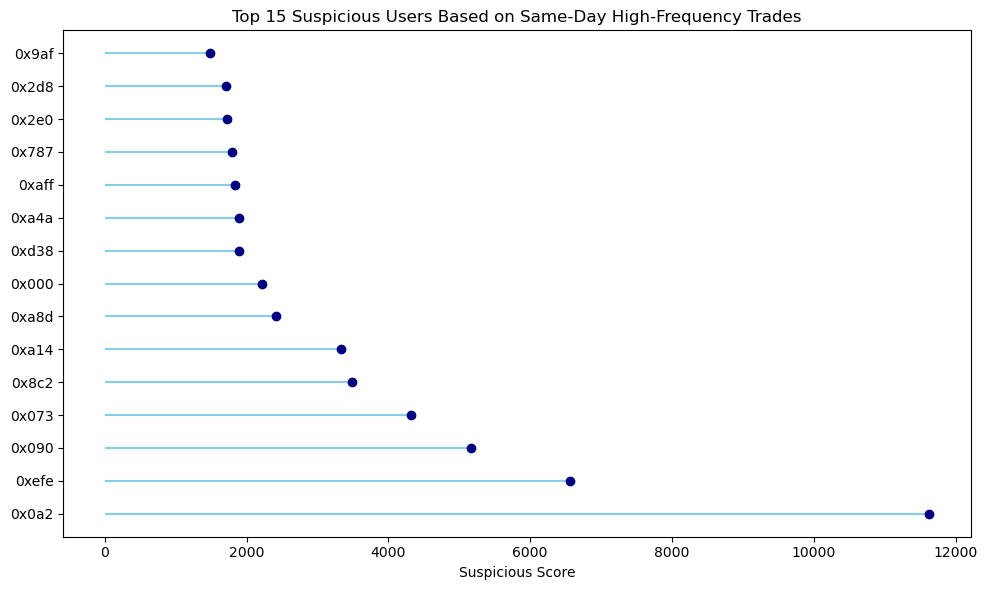

In [14]:
top15 = sorted_step3[:15]
addresses, scores = zip(*top15) #unpack top15 to address and score

plt.figure(figsize=(10, 6))

plt.hlines(y=addresses, xmin=0, xmax=scores, color='skyblue')
plt.plot(scores, addresses, 'o', color='navy')

plt.xlabel('Suspicious Score')
plt.title('Top 15 Suspicious Users Based on Same-Day High-Frequency Trades')
plt.tight_layout()
plt.show()


In [15]:
# Step 4: NFT circulation-based suspicious score
step4_scores = defaultdict(int)

# Filter out invalid NFTs
valid_nft_df = df[(df['asset.id'].notnull()) & (df['asset.id'] != 0)]

# Count number of trades per NFT
nft_trade_counts = valid_nft_df.groupby('asset.id').size()

# Select NFTs traded more than 5 times
threshold = 5
suspicious_nfts = nft_trade_counts[nft_trade_counts > threshold]

print(f"Number of suspicious NFTs with more than 5 transactions: {len(suspicious_nfts)}")

# For each suspicious NFT, increase score proportionally for sellers and buyers
for nft_id in suspicious_nfts.index:
    trades = valid_nft_df[valid_nft_df['asset.id'] == nft_id].copy()
    trades['seller_clean'] = trades['seller.address'].apply(clean_address)
    trades['buyer_clean'] = trades['winner_account.address'].apply(clean_address)

    for _, row in trades.iterrows():
        suspicious_scores[row['seller_clean']] += 1
        suspicious_scores[row['buyer_clean']] += 1
        
        step4_scores[row['seller_clean']] += 1
        step4_scores[row['buyer_clean']] += 1

# Show top 10 suspicious users based on this step
sorted_step4 = sorted(step4_scores.items(), key=lambda x: x[1], reverse=True)

print("\nTop 10 suspicious users based on repeated NFT transfers (step 4):")
for address, score in sorted_step4[:10]:
    print(f"{address}: {score} points")


Number of suspicious NFTs with more than 5 transactions: 13279

Top 10 suspicious users based on repeated NFT transfers (step 4):
0x073: 8070 points
0x95a: 6229 points
0xb1f: 4819 points
0xc21: 3836 points
0xfcf: 3109 points
0x128: 2671 points
0xd08: 2084 points
0x93a: 1808 points
0x02e: 1665 points
0xf87: 1518 points


In [16]:
#create df to have more flexible sense of time
suspicious_trades = df[df['asset.id'].isin(suspicious_nfts.index)].copy()


suspicious_trades['seller_clean'] = suspicious_trades['seller.address'].apply(clean_address)
suspicious_trades['buyer_clean'] = suspicious_trades['winner_account.address'].apply(clean_address)

suspicious_trades['sales_datetime'] = pd.to_datetime(suspicious_trades['sales_datetime'])
suspicious_trades['date_only'] = suspicious_trades['sales_datetime'].dt.date


suspicious_trades['transaction_count'] = 1


In [17]:

rows = []
for _, row in suspicious_trades.iterrows():
    # seller
    rows.append({'date': row['date_only'], 'user': row['seller_clean'], 'transaction_count': row['transaction_count']})
    # buyer
    rows.append({'date': row['date_only'], 'user': row['buyer_clean'], 'transaction_count': row['transaction_count']})

plot_df = pd.DataFrame(rows)

users = plot_df['user'].unique()
user_to_num = {user: i for i, user in enumerate(users)} # create a dict: address, index
plot_df['user_num'] = plot_df['user'].map(user_to_num) # creates new column user_num


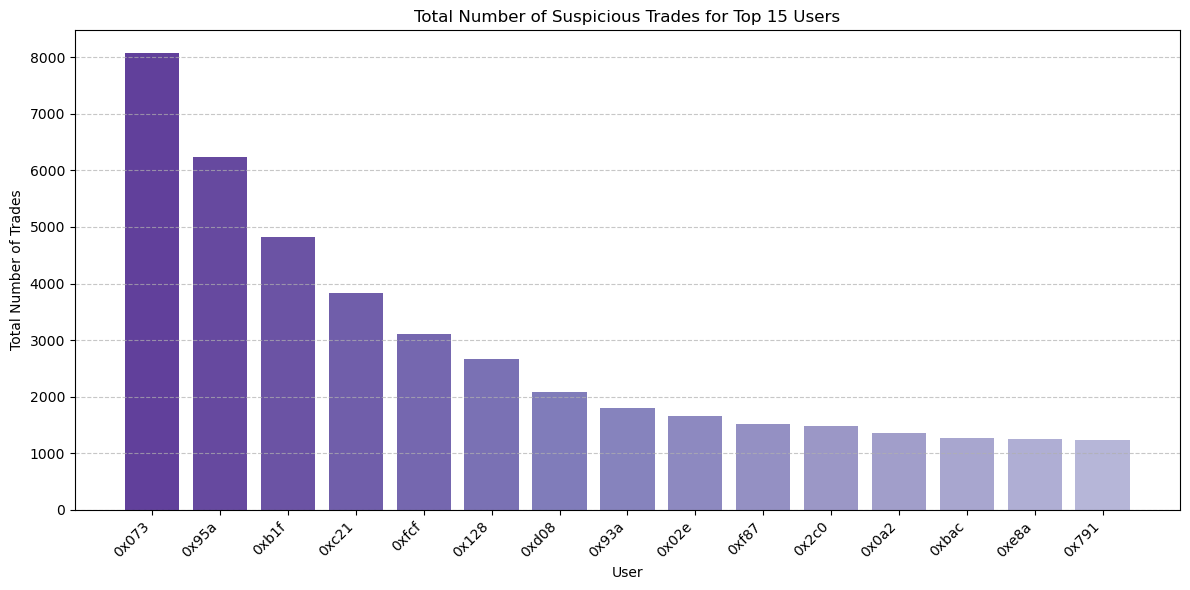

In [18]:

top_users = plot_df['user'].value_counts().head(15)

plt.figure(figsize=(12,6))


colors = cm.Purples(np.linspace(0.8, 0.4, len(top_users)))

bars = plt.bar(top_users.index, top_users.values, color=colors)

plt.title('Total Number of Suspicious Trades for Top 15 Users')
plt.xlabel('User')
plt.ylabel('Total Number of Trades')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


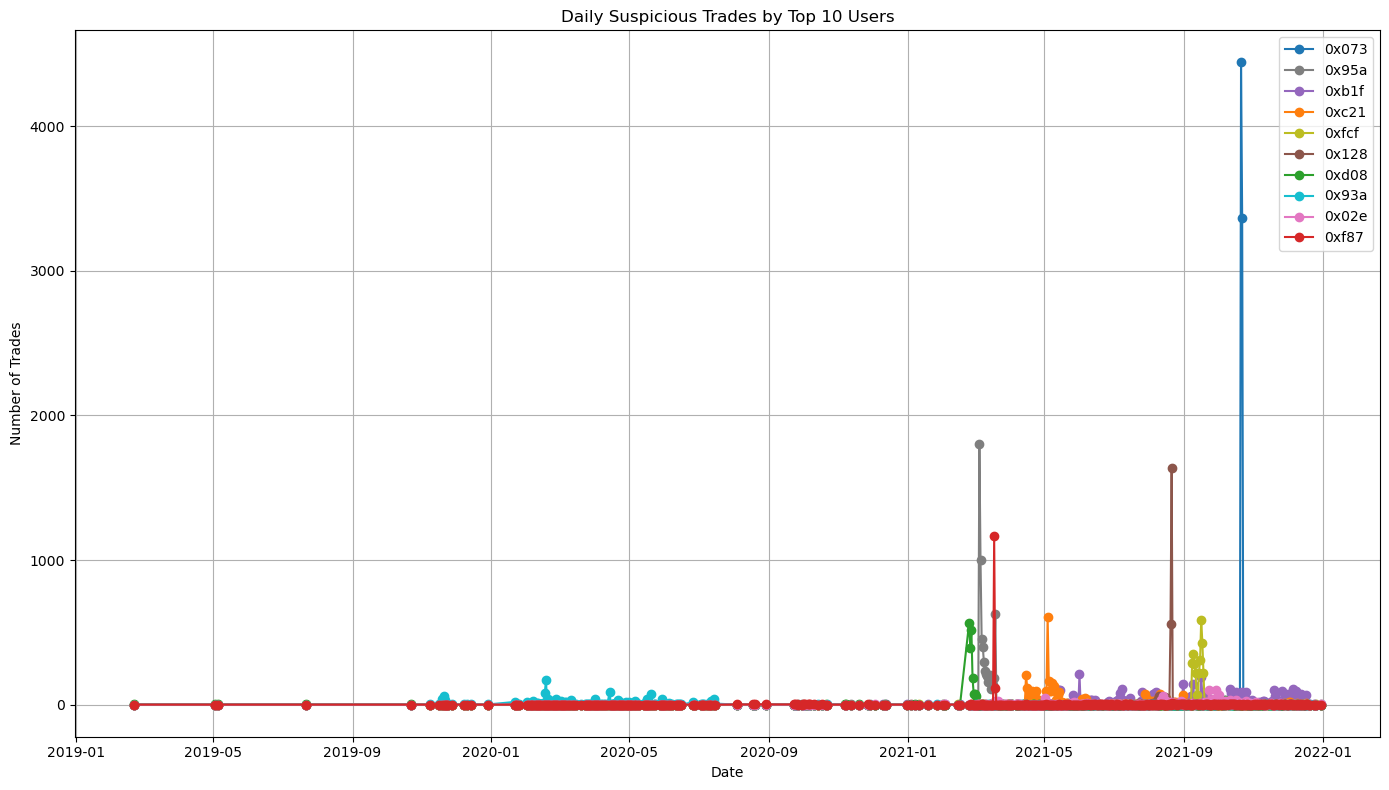

In [19]:
top_users = plot_df['user'].value_counts().head(10).index
top_user_df = plot_df[plot_df['user'].isin(top_users)]

user_daily_counts = top_user_df.groupby(['date', 'user']).size().unstack(fill_value=0)
# Dates appear as rows, users appear as columns. Null values are replaced with 0

plt.figure(figsize=(14,8))

colors = plt.get_cmap('tab10').colors  

for i, user in enumerate(top_users):
    plt.plot(
        user_daily_counts.index,
        user_daily_counts[user],
        marker='o',
        label=user,
        color=colors[7*i % 10]
    )

plt.title('Daily Suspicious Trades by Top 10 Users')
plt.xlabel('Date')
plt.ylabel('Number of Trades')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
pair_stats = df.groupby(['seller.address', 'winner_account.address']).agg(
    total_transactions=('id', 'count'),
    total_price_sum=('total_price', 'sum')
).reset_index()

print(pair_stats['total_price_sum'].describe())

count    3.862930e+06
mean     6.198592e+03
std      2.465355e+06
min      0.000000e+00
25%      8.000000e-02
50%      1.990000e-01
75%      5.000000e-01
max      3.125000e+09
Name: total_price_sum, dtype: float64


In [21]:
step5_scores = defaultdict(int)

pair_stats = df.groupby(['seller.address', 'winner_account.address']).agg(
    total_transactions=('id', 'count'), #count id column and assign its value to total_transactions
    total_price_sum=('total_price', 'sum') #sum total_price and assign its value to total_price_sum
).reset_index() # assigns to new dataframe

print(pair_stats['total_price_sum'].describe())

low_price_threshold = 0.05    # suspiciously low total price
min_transactions_threshold = 10  # minimum number of transactions to consider

suspicious_low_value_pairs = pair_stats[
    (pair_stats['total_transactions'] >= min_transactions_threshold) &
    (pair_stats['total_price_sum'] < low_price_threshold)
]

print(f"Number of suspicious low-value pairs: {len(suspicious_low_value_pairs)}")

for _, row in suspicious_low_value_pairs.iterrows():
    seller_clean = clean_address(row['seller.address'])
    buyer_clean = clean_address(row['winner_account.address'])
    
    suspicious_scores[seller_clean] += 1
    suspicious_scores[buyer_clean] += 1
    
    step5_scores[seller_clean] += 1
    step5_scores[buyer_clean] += 1

sorted_scores = sorted(suspicious_scores.items(), key=lambda x: x[1], reverse=True)
print("\nTop 10 suspicious users based on low total price trades:")
for address, score in sorted_scores[:10]:
    print(f"{address}: {score} points")


count    3.862930e+06
mean     6.198592e+03
std      2.465355e+06
min      0.000000e+00
25%      8.000000e-02
50%      1.990000e-01
75%      5.000000e-01
max      3.125000e+09
Name: total_price_sum, dtype: float64
Number of suspicious low-value pairs: 479

Top 10 suspicious users based on low total price trades:
0x0a2: 63743 points
0x073: 17729 points
0xefe: 15208 points
0x090: 12345 points
0xb1f: 9171 points
0x95a: 9106 points
0x8c2: 8256 points
0xa14: 7879 points
0x000: 7874 points
0xbdd: 7796 points


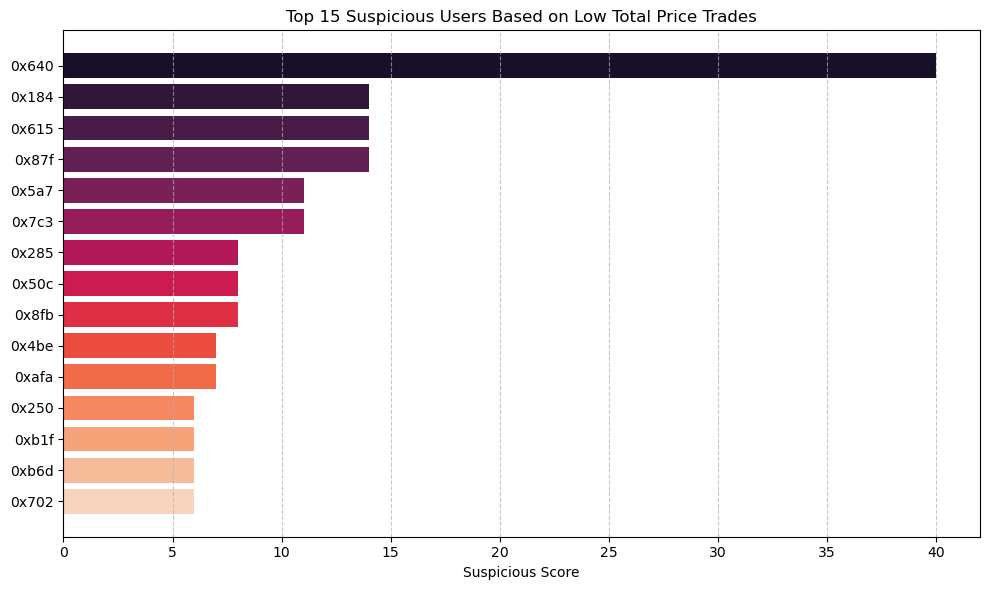

In [22]:
top15_step5 = sorted(step5_scores.items(), key=lambda x: x[1], reverse=True)[:15]
addresses, scores = zip(*top15_step5)

colors = sns.color_palette("rocket", len(scores))

plt.figure(figsize=(10, 6))
plt.barh(addresses, scores, color=colors)
plt.xlabel('Suspicious Score')
plt.title('Top 15 Suspicious Users Based on Low Total Price Trades')
plt.gca().invert_yaxis()  # highest point to top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [23]:
step6_scores = defaultdict(int)

# Self-trade transactions
self_trades = df[df['seller_clean'] == df['buyer_clean']].copy()

print(f"Number of self trades: {len(self_trades)}")

for addr in self_trades['seller_clean']:
    suspicious_scores[addr] += 10     
    step6_scores[addr] += 10           

sorted_step6 = sorted(step6_scores.items(), key=lambda x: x[1], reverse=True)

print("\nTop 15 suspicious users based on self-trading (step 6):")
for address, score in sorted_step6[:15]:
    print(f"{address}: {score} points")


Number of self trades: 1220

Top 15 suspicious users based on self-trading (step 6):
0x0a2: 130 points
0x1ad: 120 points
0xa20: 110 points
0x8c2: 100 points
0xf8d: 70 points
0x7c3: 70 points
0x740: 70 points
0xc52: 70 points
0x000: 60 points
0x3ee: 60 points
0x011: 60 points
0x5e0: 60 points
0x44f: 50 points
0xc00: 50 points
0x073: 50 points


C:\Users\zehra\AppData\Local\Temp\ipykernel_16004\593256195.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('mako')(np.linspace(0.3, 0.9, len(scores)))


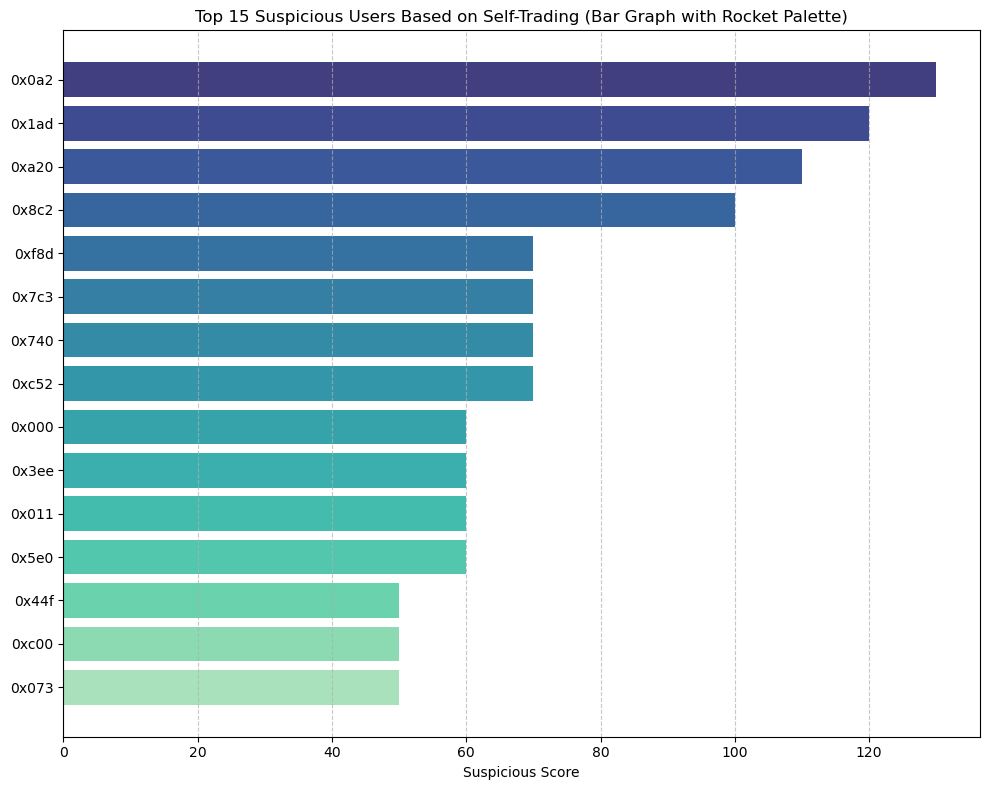

In [24]:
# En yüksek 15 kullanıcıyı al
top15_step6 = sorted_step6[:15]
addresses, scores = zip(*top15_step6)

# Rocket colormap'ten renkleri al
colors = cm.get_cmap('mako')(np.linspace(0.3, 0.9, len(scores)))

plt.figure(figsize=(10, 8))

# Yatay bar grafiği çiz
bars = plt.barh(addresses, scores, color=colors)

plt.xlabel('Suspicious Score')
plt.title('Top 15 Suspicious Users Based on Self-Trading (Bar Graph with Rocket Palette)')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# En yüksek skoru üstte göstermek için y eksenini ters çevir
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


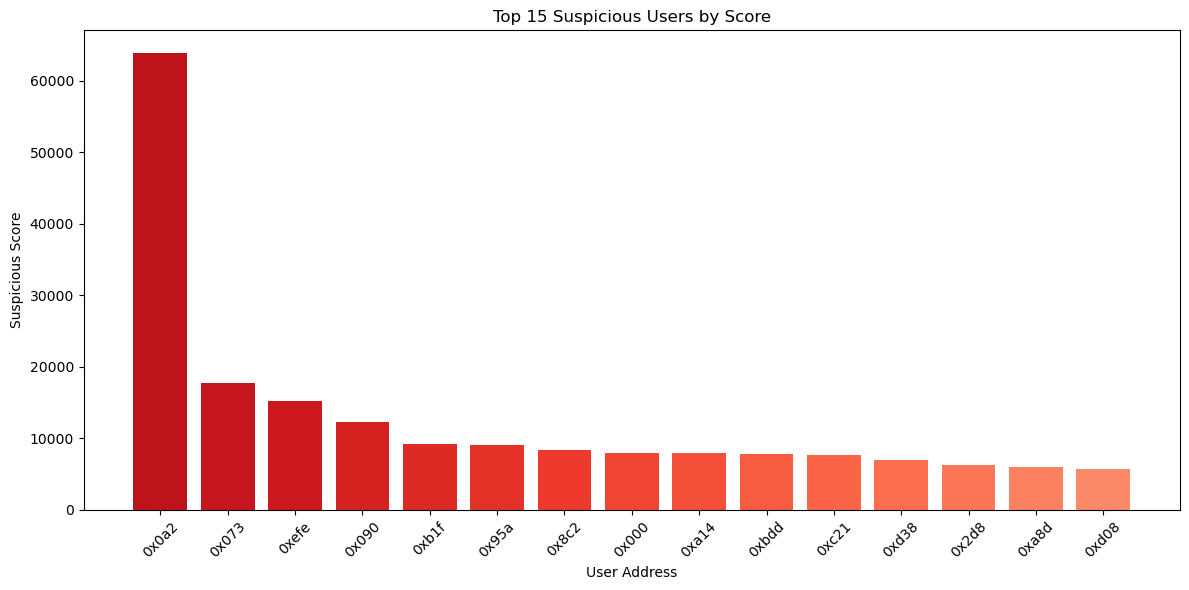

In [25]:
sorted_scores = sorted(suspicious_scores.items(), key=lambda x: x[1], reverse=True)

top_n = 15
top_users = sorted_scores[:top_n]

addresses = [x[0] for x in top_users]
scores = [x[1] for x in top_users]

colors = cm.Reds(np.linspace(0.8, 0.4, len(scores)))

plt.figure(figsize=(12,6))
plt.bar(addresses, scores, color=colors)
plt.xlabel('User Address')
plt.ylabel('Suspicious Score')
plt.title(f'Top {top_n} Suspicious Users by Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [26]:
for addr, score in sorted_scores[:10]:
    print(f"{addr}: {score}")


0x0a2: 63873
0x073: 17779
0xefe: 15208
0x090: 12345
0xb1f: 9181
0x95a: 9106
0x8c2: 8356
0x000: 7934
0xa14: 7889
0xbdd: 7816
